# Code file for model : Propensity Score Matching with Logistic Regression

### Installing pandas version 0.23.4 for matching library to work

In [1]:
!pip install pandas==0.23.4

Looking in indexes: http://archive.linux.duke.edu/pypi/simple/


### Importing relevant python libraries

In [2]:
import numpy as np
import pandas as pd
from pymatch.Matcher import Matcher
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices

%matplotlib inline

### Checking pandas library version

In [3]:
pd.__version__

'0.23.4'

### Reading brazil_100k dataset

In [4]:
brazil = pd.read_csv('brazil_100k.txt')
brazil.drop(columns='CID', inplace=True)
brazil.info()
brazil.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
FID           100000 non-null int64
thre2011      100000 non-null float64
thre2017      100000 non-null float64
precip2011    100000 non-null float64
precip2017    100000 non-null float64
air2011       100000 non-null float64
air2017       100000 non-null float64
slope         100000 non-null float64
elevation     100000 non-null int64
DistToRoad    100000 non-null float64
acc_50k       100000 non-null int64
dtypes: float64(8), int64(3)
memory usage: 8.4 MB


,FID,thre2011,thre2017,precip2011,precip2017,air2011,air2017,slope,elevation,DistToRoad,acc_50k
0,0,900.0,900.0,19.566700,18.599199,27.541700,26.850000,0.202823,96,0.025871,527
1,1,244.0,226.0,15.299200,15.382500,26.799999,26.666700,0.401320,261,0.000000,145
2,2,900.0,900.0,22.350800,22.298300,26.366699,26.316700,0.010129,100,0.613321,4113
3,3,900.0,900.0,22.016701,22.715799,27.316700,27.375000,0.028648,41,1.351790,4169
4,4,898.0,898.0,16.325800,17.838301,25.966700,24.516701,0.036519,200,0.375023,1158


### Read in PES dataset

In [5]:
pes = pd.read_csv('within_pes_100k.csv')
pes.drop(columns='Unnamed: 0', inplace=True)
pes.info()
pes.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99641 entries, 0 to 99640
Data columns (total 2 columns):
FID           99641 non-null int64
within_pes    99641 non-null int64
dtypes: int64(2)
memory usage: 1.5 MB


,FID,within_pes
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


### Read in PA dataset

In [6]:
pa = pd.read_csv('within_pa_100k.csv')
pa.drop(columns='Unnamed: 0', inplace=True)
pa.info()
pa.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99641 entries, 0 to 99640
Data columns (total 2 columns):
FID          99641 non-null int64
within_pa    99641 non-null int64
dtypes: int64(2)
memory usage: 1.5 MB


,FID,within_pa
0,0,1
1,1,0
2,2,1
3,3,0
4,4,0


### Read in group dataset

In [7]:
grp = pd.read_csv('group_100k.csv')
grp.drop(columns=['Unnamed: 0', 'slope', 'elevation', 'DistToRoad', 'acc_50k',
                 'precip2011', 'precip2017', 'air2011', 'air2017'], inplace=True)
grp.info()
grp.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99641 entries, 0 to 99640
Data columns (total 2 columns):
FID      99641 non-null int64
group    99641 non-null int64
dtypes: int64(2)
memory usage: 1.5 MB


,FID,group
0,0,0
1,1,3
2,2,1
3,3,1
4,4,3


### Merge (Inner) all 4 datasets on common key column: "FID"

In [8]:
brazil_grp = brazil.merge(grp, how='inner', on='FID')
brazil_grp_pes = brazil_grp.merge(pes, how='inner', on='FID')
brazil_grp_pes_pa = brazil_grp_pes.merge(pa, how='inner', on='FID')

In [9]:
brazil_grp_pes_pa.info()
brazil_grp_pes_pa.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99641 entries, 0 to 99640
Data columns (total 14 columns):
FID           99641 non-null int64
thre2011      99641 non-null float64
thre2017      99641 non-null float64
precip2011    99641 non-null float64
precip2017    99641 non-null float64
air2011       99641 non-null float64
air2017       99641 non-null float64
slope         99641 non-null float64
elevation     99641 non-null int64
DistToRoad    99641 non-null float64
acc_50k       99641 non-null int64
group         99641 non-null int64
within_pes    99641 non-null int64
within_pa     99641 non-null int64
dtypes: float64(8), int64(6)
memory usage: 11.4 MB


,FID,thre2011,thre2017,precip2011,precip2017,air2011,air2017,slope,elevation,DistToRoad,acc_50k,group,within_pes,within_pa
0,0,900.0,900.0,19.566700,18.599199,27.541700,26.850000,0.202823,96,0.025871,527,0,1,1
1,1,244.0,226.0,15.299200,15.382500,26.799999,26.666700,0.401320,261,0.000000,145,3,0,0
2,2,900.0,900.0,22.350800,22.298300,26.366699,26.316700,0.010129,100,0.613321,4113,1,0,1
3,3,900.0,900.0,22.016701,22.715799,27.316700,27.375000,0.028648,41,1.351790,4169,1,0,0
4,4,898.0,898.0,16.325800,17.838301,25.966700,24.516701,0.036519,200,0.375023,1158,3,0,0


### Calculate forest cover loss(fcl) = threshold 2011 - threshold 2017

In [10]:
brazil_grp_pes_pa['fcl'] = (brazil_grp_pes_pa['thre2011'] - brazil_grp_pes_pa['thre2017'])/900

# Converting forest loss in binary variable: 1 if loss is > 0 or 0 otherwise
brazil_grp_pes_pa['loss'] = brazil_grp_pes_pa['fcl'].apply(lambda x: 0 if x == 0 else 1)

In [11]:
brazil_grp_pes_pa.info()
brazil_grp_pes_pa.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99641 entries, 0 to 99640
Data columns (total 16 columns):
FID           99641 non-null int64
thre2011      99641 non-null float64
thre2017      99641 non-null float64
precip2011    99641 non-null float64
precip2017    99641 non-null float64
air2011       99641 non-null float64
air2017       99641 non-null float64
slope         99641 non-null float64
elevation     99641 non-null int64
DistToRoad    99641 non-null float64
acc_50k       99641 non-null int64
group         99641 non-null int64
within_pes    99641 non-null int64
within_pa     99641 non-null int64
fcl           99641 non-null float64
loss          99641 non-null int64
dtypes: float64(9), int64(7)
memory usage: 12.9 MB


,FID,thre2011,thre2017,precip2011,precip2017,air2011,air2017,slope,elevation,DistToRoad,acc_50k,group,within_pes,within_pa,fcl,loss
0,0,900.0,900.0,19.566700,18.599199,27.541700,26.850000,0.202823,96,0.025871,527,0,1,1,0.00,0
1,1,244.0,226.0,15.299200,15.382500,26.799999,26.666700,0.401320,261,0.000000,145,3,0,0,0.02,1
2,2,900.0,900.0,22.350800,22.298300,26.366699,26.316700,0.010129,100,0.613321,4113,1,0,1,0.00,0
3,3,900.0,900.0,22.016701,22.715799,27.316700,27.375000,0.028648,41,1.351790,4169,1,0,0,0.00,0
4,4,898.0,898.0,16.325800,17.838301,25.966700,24.516701,0.036519,200,0.375023,1158,3,0,0,0.00,0


In [12]:
#Make copy of the merged dataset
df = brazil_grp_pes_pa.copy() 

In [13]:
#Count observations for the binary forest cover loss
df.loss.value_counts() 

0    69760
1    29881
Name: loss, dtype: int64

In [14]:
# Drop unnecessary columns
df.drop(columns=['FID', 'precip2017', 'air2017', 'thre2011', 'thre2017', 'group'], inplace=True)
df.describe()

,precip2011,air2011,slope,elevation,DistToRoad,acc_50k,within_pes,within_pa,fcl,loss
count,99641.000000,99641.000000,99641.000000,99641.000000,99641.000000,99641.000000,99641.000000,99641.000000,99641.000000,99641.000000
mean,19.569500,26.423997,0.312456,165.444466,0.916337,1735.574653,0.092964,0.271475,0.028549,0.299887
std,3.775537,1.149533,0.617889,130.642501,0.900006,1517.721446,0.290383,0.444723,0.098154,0.458210
min,9.404170,16.691700,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.531700,25.941700,0.022648,79.000000,0.223305,529.000000,0.000000,0.000000,0.000000,0.000000
50%,19.414200,26.558300,0.091157,103.000000,0.615295,1302.000000,0.000000,0.000000,0.000000,0.000000
75%,22.281700,27.183300,0.324743,219.000000,1.325920,2539.000000,0.000000,1.000000,0.002222,1.000000
max,33.845001,28.758301,20.024401,2445.000000,4.517360,9154.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# Check sample observations of the datafram after all the merging and preprocessing
df.head()

,precip2011,air2011,slope,elevation,DistToRoad,acc_50k,within_pes,within_pa,fcl,loss
0,19.566700,27.541700,0.202823,96,0.025871,527,1,1,0.00,0
1,15.299200,26.799999,0.401320,261,0.000000,145,0,0,0.02,1
2,22.350800,26.366699,0.010129,100,0.613321,4113,0,1,0.00,0
3,22.016701,27.316700,0.028648,41,1.351790,4169,0,0,0.00,0
4,16.325800,25.966700,0.036519,200,0.375023,1158,0,0,0.00,0


In [16]:
### Balance tables for mean of covariates before matching for PES only

In [17]:
for i in ['slope', 'elevation', 'DistToRoad', 'acc_50k', 'precip2011', 'air2011']:
    pes = df.loc[df.within_pes == 1, i].mean()
    no_pes = df.loc[df.within_pes == 0, i].mean()
    pvalue = stats.ttest_ind(df.loc[df.within_pes == 1, i].values,
                            df.loc[df.within_pes == 0, i].values).pvalue
    print(f'For {i}, the mean for pes is {pes:.2f},' )
    print(f'          the mean for no_pes is {no_pes:.2f},')
    print(f'and the p-value for this difference is {pvalue:.2f}')
    print('\n')

For slope, the mean for pes is 0.25,
          the mean for no_pes is 0.32,
and the p-value for this difference is 0.00


For elevation, the mean for pes is 130.02,
          the mean for no_pes is 169.08,
and the p-value for this difference is 0.00


For DistToRoad, the mean for pes is 0.62,
          the mean for no_pes is 0.95,
and the p-value for this difference is 0.00


For acc_50k, the mean for pes is 1743.60,
          the mean for no_pes is 1734.75,
and the p-value for this difference is 0.59


For precip2011, the mean for pes is 20.00,
          the mean for no_pes is 19.53,
and the p-value for this difference is 0.00


For air2011, the mean for pes is 26.87,
          the mean for no_pes is 26.38,
and the p-value for this difference is 0.00




In [18]:
# Divide dataset into test and control groups without considering effect of PES
test = df[df.within_pes == 1]
control = df[df.within_pes == 0]

In [19]:
# Set matcher object
m = Matcher(test, control, yvar="within_pes", exclude=['within_pes', 'within_pa', 'loss', 'fcl'])

Formula:
within_pes ~ precip2011+air2011+slope+elevation+DistToRoad+acc_50k
n majority: 90378
n minority: 9263


In [20]:
# Fitting matcher object
np.random.seed(1)
m.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 100\100
Average Accuracy: 62.02%


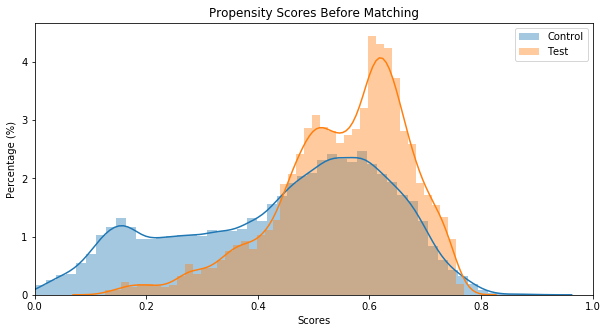

In [21]:
# Plotting propensity scores
m.predict_scores()
m.plot_scores()

In [22]:
# K:1 Matching
m.match(method='min', nmatches=1)

C:\ProgramData\Anaconda3\lib\site-packages\pymatch\Matcher.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['match_id'] = match_ids
C:\ProgramData\Anaconda3\lib\site-packages\pymatch\Matcher.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.matched_data['record_id'] = self.matched_data.index


In [23]:
m.record_frequency()

,freq,n_records
0,1,16724
1,2,766
2,3,82
3,4,6


In [24]:
# Assign weight vector based on matching
m.assign_weight_vector()

In [25]:
# Get matched dataset
matched = m.matched_data.sort_values('match_id')
matched.head(10)

,record_id,weight,precip2011,air2011,slope,elevation,DistToRoad,acc_50k,within_pes,within_pa,fcl,loss,scores,match_id
0,0,1.0,19.566700,27.541700,0.202823,96,0.025871,527,1,1,0.000000,0,0.676110,0
16990,87470,1.0,12.473300,27.791700,0.010129,76,0.018294,13,0,0,0.000000,0,0.676111,0
1,1,1.0,19.481701,27.233299,0.000000,100,0.082322,758,1,1,0.000000,0,0.642357,1
17077,88133,1.0,23.035000,27.241699,0.000000,1,0.545527,1271,0,1,0.061111,1,0.642355,1
12964,42702,0.5,21.742500,27.783300,0.446682,89,1.474670,3386,0,0,0.000000,0,0.621752,2
2,2,1.0,19.628300,27.216700,0.032029,57,0.421354,1077,1,0,0.000000,0,0.621762,2
3,3,1.0,16.410801,25.866699,0.042972,94,0.737277,4008,1,1,0.000000,0,0.539572,3
14087,58734,1.0,15.055800,26.783300,0.240752,136,0.124411,204,0,0,0.044444,1,0.539567,3
18396,98424,1.0,23.334200,25.750000,0.010129,23,0.000000,101,0,0,0.111111,1,0.496938,4
4,4,1.0,15.125800,26.633301,0.000000,200,0.082322,177,1,1,0.000000,0,0.496938,4


In [26]:
# Balance tables after matching
matched.groupby('within_pes').mean()

,record_id,weight,precip2011,air2011,slope,elevation,DistToRoad,acc_50k,within_pa,fcl,loss,scores,match_id
within_pes,,,,,,,,,,,,,
0,54671.527799,0.897657,19.949239,26.850433,0.23637,123.293857,0.636467,1775.127173,0.266760,0.028267,0.302062,0.552982,4631.0
1,4631.000000,1.000000,19.998899,26.868143,0.24729,130.019864,0.622463,1743.601857,0.679585,0.015408,0.204253,0.552982,4631.0


In [27]:
# See matched dataset description
matched.describe()

,record_id,weight,precip2011,air2011,slope,elevation,DistToRoad,acc_50k,within_pes,within_pa,fcl,loss,scores,match_id
count,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000,18526.000000
mean,29651.263899,0.948829,19.974069,26.859288,0.241830,126.656861,0.629465,1759.364515,0.500000,0.473173,0.021837,0.253158,0.552982,4631.000000
std,32228.219535,0.157120,3.628543,0.721063,0.467370,87.472795,0.665494,1433.287712,0.500013,0.499293,0.083512,0.434832,0.117554,2674.069928
min,0.000000,0.250000,10.343300,23.091700,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.126806,0.000000
25%,4631.250000,1.000000,17.049999,26.358299,0.014324,72.000000,0.187679,653.000000,0.000000,0.000000,0.000000,0.000000,0.484924,2315.250000
50%,9262.500000,1.000000,19.830000,26.875000,0.070900,100.000000,0.457345,1369.500000,0.500000,0.000000,0.000000,0.000000,0.573109,4631.000000
75%,56096.250000,1.000000,22.719200,27.416700,0.241602,198.000000,0.814948,2533.000000,1.000000,1.000000,0.001111,1.000000,0.637831,6946.750000
max,99635.000000,1.000000,33.845001,28.758301,8.381690,1058.000000,4.445900,8565.000000,1.000000,1.000000,1.000000,1.000000,0.768882,9262.000000


In [28]:
weight = matched['weight'].values

In [29]:
y1, X1 = dmatrices('loss ~ slope + elevation + DistToRoad + acc_50k + precip2011 + air2011 + C(within_pes) * C(within_pa)', 
                 matched, return_type = 'dataframe')
X1.head()

,Intercept,C(within_pes)[T.1],C(within_pa)[T.1],C(within_pes)[T.1]:C(within_pa)[T.1],slope,elevation,DistToRoad,acc_50k,precip2011,air2011
0,1.0,1.0,1.0,1.0,0.202823,96.0,0.025871,527.0,19.566700,27.541700
16990,1.0,0.0,0.0,0.0,0.010129,76.0,0.018294,13.0,12.473300,27.791700
1,1.0,1.0,1.0,1.0,0.000000,100.0,0.082322,758.0,19.481701,27.233299
17077,1.0,0.0,1.0,0.0,0.000000,1.0,0.545527,1271.0,23.035000,27.241699
12964,1.0,0.0,0.0,0.0,0.446682,89.0,1.474670,3386.0,21.742500,27.783300


In [30]:
# Fitting logistic regression after matching
sm.Logit(y1, X1, weights=weight).fit().summary()

Optimization terminated successfully.
         Current function value: 0.487258
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   loss   No. Observations:                18526
Model:                          Logit   Df Residuals:                    18516
Method:                           MLE   Df Model:                            9
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                  0.1388
Time:                        02:48:11   Log-Likelihood:                -9026.9
converged:                       True   LL-Null:                       -10482.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                               10.6719      0.752     14.192      0.000       9.198      12.146
C(within_pes)[T.1]                      -0.2866      0.052     -5.469      0.000      -0.389      -0.184
C(within_pa)[T.1]                       -0.6289      0.063     -9.955      0.000      -0.753      -0.505
C(within_pes)[T.1]:C(within_pa)[T.1]     0.0901      0.086      1.045      0.296      -0.079       0.259
slope                                    0.2496      0.044      5.699      0.000       0.164       0.335
elevation                               -0.0036      0.000    -12.566      0.000      -0.004      -0.003
DistToRoad                              -0.1228      0.041     -2.976      0.003      -0.204      -0.042
acc_50k                                 -0.0006   2.21e-05    -27.010      0.000      -0.001      -0.001
precip2011                              -0.0578      0.006     -9.335      0.000      -0.070      -0.046
air2011                                 -0.3328      0.028    -11.997      0.000      -0.387      -0.278
========================================================================================================
"""

### Extract dataset with PES values for PA=1 only

In [31]:
df_pa = df[df['within_pa']==1]
df_pa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27050 entries, 0 to 99638
Data columns (total 10 columns):
precip2011    27050 non-null float64
air2011       27050 non-null float64
slope         27050 non-null float64
elevation     27050 non-null int64
DistToRoad    27050 non-null float64
acc_50k       27050 non-null int64
within_pes    27050 non-null int64
within_pa     27050 non-null int64
fcl           27050 non-null float64
loss          27050 non-null int64
dtypes: float64(5), int64(5)
memory usage: 2.3 MB


In [32]:
### Balance tables for PES with PA=1 only before matching

In [33]:
for i in ['slope', 'elevation', 'DistToRoad', 'acc_50k', 'precip2011', 'air2011']:
    pa_pes = df_pa.loc[df_pa.within_pes == 1, i].mean()
    pa_no_pes = df_pa.loc[df_pa.within_pes == 0, i].mean()
    pvalue_pa = stats.ttest_ind(df_pa.loc[df_pa.within_pes == 1, i].values,
                            df_pa.loc[df_pa.within_pes == 0, i].values).pvalue
    print(f'For {i}, the mean for pes is {pa_pes:.2f},' )
    print(f'          the mean for no_pes is {pa_no_pes:.2f},')
    print(f'and the p-value for this difference is {pvalue_pa:.2f}')
    print('\n')

For slope, the mean for pes is 0.24,
          the mean for no_pes is 0.34,
and the p-value for this difference is 0.00


For elevation, the mean for pes is 135.20,
          the mean for no_pes is 151.24,
and the p-value for this difference is 0.00


For DistToRoad, the mean for pes is 0.73,
          the mean for no_pes is 0.98,
and the p-value for this difference is 0.00


For acc_50k, the mean for pes is 1947.46,
          the mean for no_pes is 2134.80,
and the p-value for this difference is 0.00


For precip2011, the mean for pes is 19.55,
          the mean for no_pes is 20.61,
and the p-value for this difference is 0.00


For air2011, the mean for pes is 26.78,
          the mean for no_pes is 26.74,
and the p-value for this difference is 0.00




### Repeat the same analysis but for PES=1 only

In [34]:
# Divide dataset for PES=1 into test and control groups
test1 = df_pa[df_pa.within_pes == 1]
control1 = df_pa[df_pa.within_pes == 0]

In [35]:
# Instatiate new matcher object
m1 = Matcher(test1, control1, yvar="within_pes", exclude=['within_pes', 'within_pa', 'loss', 'fcl'])

Formula:
within_pes ~ precip2011+air2011+slope+elevation+DistToRoad+acc_50k
n majority: 20755
n minority: 6295


In [36]:
# Fit matcher object
np.random.seed(1)
m1.fit_scores(balance=True, nmodels=100)

Fitting Models on Balanced Samples: 1\100

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Fitting Models on Balanced Samples: 100\100
Average Accuracy: 60.56%


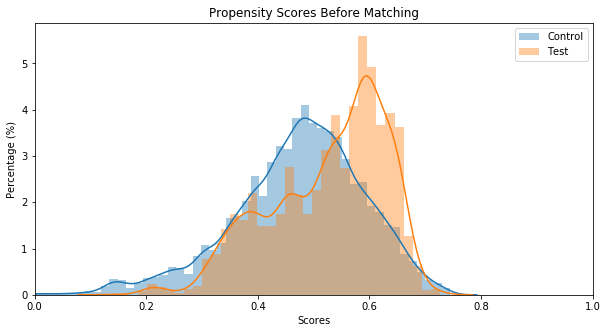

In [37]:
# Get propensity scores 
m1.predict_scores()
m1.plot_scores()

In [38]:
# K:1 Matching
m1.match(method='min', nmatches=1)

In [39]:
m1.record_frequency()

,freq,n_records
0,1,9915
1,2,789
2,3,210
3,4,74
4,5,23
5,6,7
6,7,2


In [40]:
# Assign weight vector based on matching
m1.assign_weight_vector()

In [41]:
# Get matched dataset
matched1 = m1.matched_data.sort_values('match_id')
matched1.head(10)

,record_id,weight,precip2011,air2011,slope,elevation,DistToRoad,acc_50k,within_pes,within_pa,fcl,loss,scores,match_id
0,0,1.000000,19.566700,27.541700,0.202823,96,0.025871,527,1,1,0.0,0,0.584708,0
7785,9340,1.000000,19.749201,27.083300,0.010129,75,0.410797,1435,0,1,0.0,0,0.584724,0
1,1,1.000000,19.481701,27.233299,0.000000,100,0.082322,758,1,1,0.0,0,0.595823,1
6548,6811,0.500000,19.562500,26.441700,0.000000,100,0.423730,3423,0,1,0.0,0,0.595832,1
7657,9098,0.333333,15.834200,25.508301,0.045296,195,0.036588,2109,0,1,0.0,0,0.652116,2
2,2,1.000000,16.410801,25.866699,0.042972,94,0.737277,4008,1,1,0.0,0,0.652124,2
8017,9855,0.500000,15.834200,25.508301,0.000000,200,0.156302,1602,0,1,0.0,0,0.639880,3
3,3,1.000000,15.125800,26.633301,0.000000,200,0.082322,177,1,1,0.0,0,0.639881,3
6790,7284,1.000000,22.016701,27.316700,0.000000,52,0.900913,1685,0,1,0.0,0,0.508117,4
4,4,1.000000,21.249201,26.525000,0.028648,71,1.133220,2263,1,1,0.0,0,0.508125,4


In [42]:
# Balance tables after matching for PES=1 
matched1.groupby('within_pes').mean()

,record_id,weight,precip2011,air2011,slope,elevation,DistToRoad,acc_50k,within_pa,fcl,loss,scores,match_id
within_pes,,,,,,,,,,,,,
0,15935.728674,0.750596,19.577321,26.776578,0.236218,133.844480,0.730412,1898.788880,1.0,0.013174,0.211438,0.525963,3147.0
1,3147.000000,1.000000,19.550147,26.777281,0.242786,135.204925,0.728684,1947.459095,1.0,0.009151,0.163940,0.525963,3147.0


In [43]:
weight1 = matched1['weight'].values

In [44]:
y2, X2 = dmatrices('loss ~ slope + elevation + DistToRoad + acc_50k + precip2011 + air2011 + C(within_pes) * C(within_pa)', 
                 matched1, return_type = 'dataframe')
X2.head()

,Intercept,C(within_pes)[T.1],slope,elevation,DistToRoad,acc_50k,precip2011,air2011
0,1.0,1.0,0.202823,96.0,0.025871,527.0,19.566700,27.541700
7785,1.0,0.0,0.010129,75.0,0.410797,1435.0,19.749201,27.083300
1,1.0,1.0,0.000000,100.0,0.082322,758.0,19.481701,27.233299
6548,1.0,0.0,0.000000,100.0,0.423730,3423.0,19.562500,26.441700
7657,1.0,0.0,0.045296,195.0,0.036588,2109.0,15.834200,25.508301


In [45]:
# Fit logistic regression for PES=1 
sm.Logit(y2, X2, weights=weight1).fit().summary()

Optimization terminated successfully.
         Current function value: 0.449343
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   loss   No. Observations:                12590
Model:                          Logit   Df Residuals:                    12582
Method:                           MLE   Df Model:                            7
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                 0.06940
Time:                        02:48:55   Log-Likelihood:                -5657.2
converged:                       True   LL-Null:                       -6079.1
Covariance Type:            nonrobust   LLR p-value:                6.473e-178
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             14.7490      0.953     15.471      0.000      12.881      16.618
C(within_pes)[T.1]    -0.3003      0.048     -6.310      0.000      -0.394      -0.207
slope                  0.3750      0.057      6.629      0.000       0.264       0.486
elevation             -0.0049      0.000    -13.577      0.000      -0.006      -0.004
DistToRoad            -0.2593      0.044     -5.930      0.000      -0.345      -0.174
acc_50k               -0.0003   2.42e-05    -12.444      0.000      -0.000      -0.000
precip2011            -0.0342      0.008     -4.433      0.000      -0.049      -0.019
air2011               -0.5302      0.035    -15.108      0.000      -0.599      -0.461
======================================================================================
"""